# Rainbowization

This notebook transforms the color palette of input photos into one distributed in hue.


In [1]:
%matplotlib inline
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from skimage.color import rgb2hsv,hsv2rgb
from skimage.util import img_as_float
import numpy as np
import math
import random
import os
from skimage.transform import rescale

In [2]:
testfile = 'DSCF3264_1024.jpg'
testimage = mpimg.imread(testfile)

In [3]:
def clusterimage(image,numbercenters):
    image = img_as_float(image)
    pic_n = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    kmeans = KMeans(n_clusters=numbercenters, random_state=0,max_iter=3,n_init=1).fit(pic_n)
    pic2show = kmeans.cluster_centers_[kmeans.labels_]    
    cluster_pic = pic2show.reshape(image.shape[0], image.shape[1], image.shape[2])
    return kmeans

testkmeans = clusterimage(testimage,7)

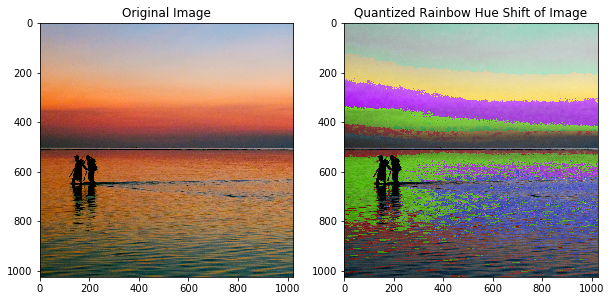

In [4]:
def quantizedhue(image,kmeans):
    numbercenters = kmeans.cluster_centers_.shape[0]
    clustermap = kmeans.labels_.reshape(image.shape[0], image.shape[1])

    # Basically what we want to do is a hue-based conversion per label
    # So one idea would be to transform the image into H,S,V space and operate purely on
    # hue channel
    hsvimg = rgb2hsv(image)

    huetransformmask = np.zeros([image.shape[0], image.shape[1]],dtype = 'float')
    for r in range(0,numbercenters):
        out = np.where(clustermap==r)
        for x,y in zip(out[0],out[1]):
            huetransformmask[x,y] = r/numbercenters

    # Straightforward way of adding - note it carries the quantization noise of the encoding
    # Could try 'fuzzier' clustering as a portion of membership of each cluster by distance
    # to centroid!
    alphaparam = 0.1
    hsvimg[:,:,0] = alphaparam*hsvimg[:,:,0] + (1-alphaparam)*huetransformmask
    outimg = hsv2rgb(hsvimg)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Quantized Rainbow Hue Shift of Image')
    ax2.imshow(outimg)

    return outimg

qhueimg = quantizedhue(testimage,testkmeans)

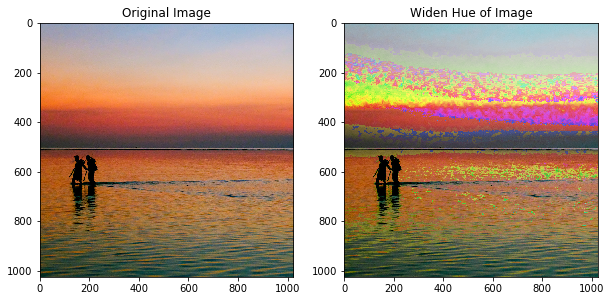

In [5]:
def widenhue(image,kmeans):
    # In each centroid, move the hue slightly away from the mean
    numbercenters = kmeans.cluster_centers_.shape[0]
    clustermap = kmeans.labels_.reshape(image.shape[0], image.shape[1])
    hsvimg = rgb2hsv(image)
    widenfactor = 1/6
    
    huetransformmask = np.zeros([image.shape[0], image.shape[1]],dtype = 'float')
    for r in range(0,numbercenters):
        out = np.where(clustermap==r)
        avghue = np.average(hsvimg[out[0],out[1],0])
        stddev = np.std(hsvimg[out[0],out[1],0])
        huetransformmask[out[0],out[1]] = (widenfactor/stddev) * (hsvimg[out[0],out[1],0] - avghue) + avghue       
    huetransformmask = (huetransformmask + 1) % 1
    outimg = hsvimg
    outimg[:,:,0] = huetransformmask
    outimg = hsv2rgb(outimg)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(12,12)
    ax1.set_title('Original Image')
    ax1.imshow(image)
    ax2.set_title('Widen Hue of Image')
    ax2.imshow(outimg)

    return outimg

widenhueimg = widenhue(testimage,testkmeans)

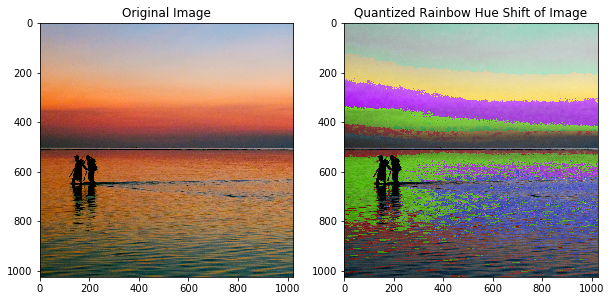

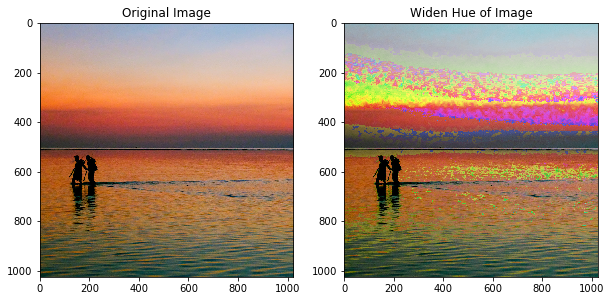

In [6]:
def rainbowize(image):
    numbercenters = 7
    kmeans = clusterimage(image,numbercenters)
    outimages = []
    outimages.append(quantizedhue(image,kmeans))
    outimages.append(widenhue(image,kmeans))
    return outimages

outhueimglist = rainbowize(testimage)

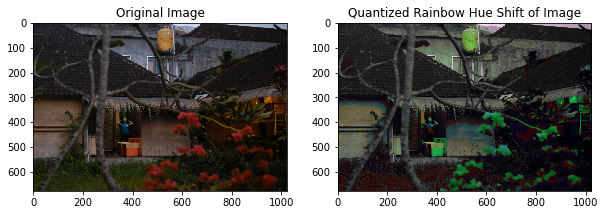

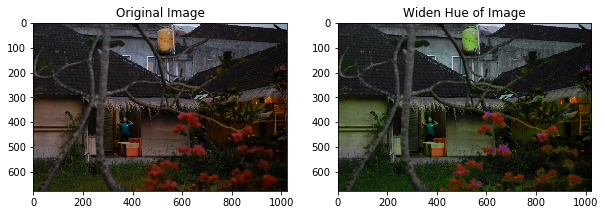

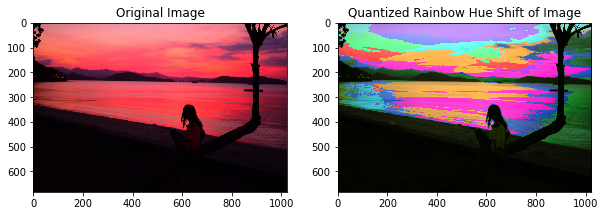

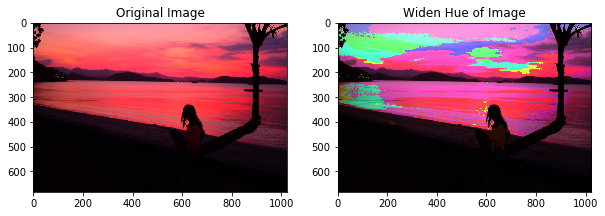

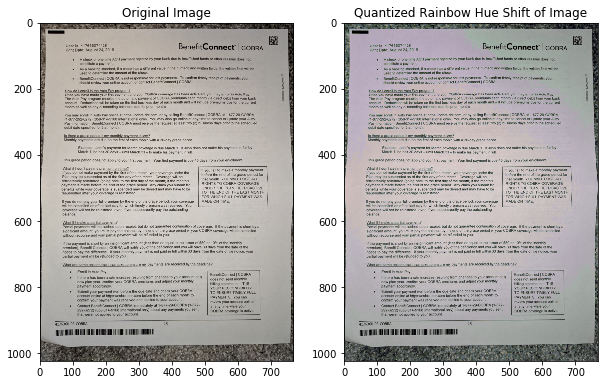

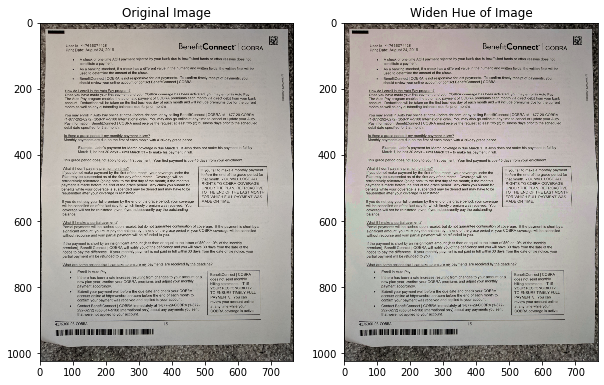

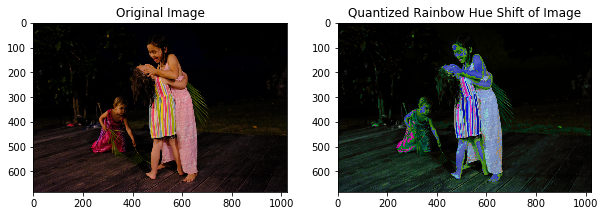

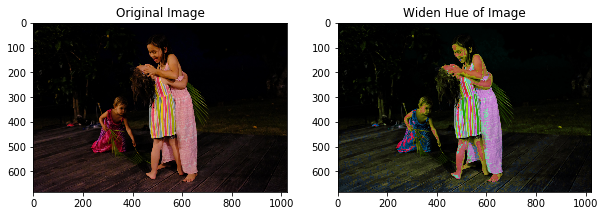

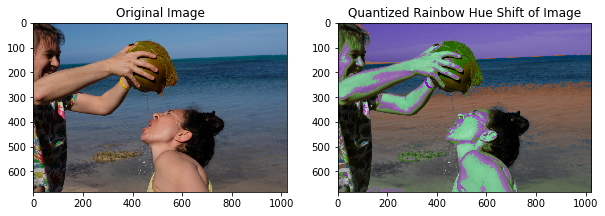

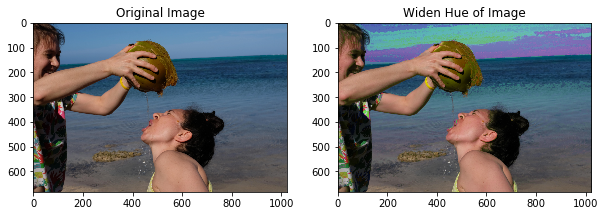

In [12]:
# load input files and set parameters
# change later to run this across selected files or randomly across photos in image directories
numberoffiles = 5
path = '/Users/jimkleban/Desktop/Stuff'
outpath = '/Users/jimkleban/Desktop/Autogenerated/'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.jpg' in file:
            files.append(os.path.join(r, file))

random.shuffle(files)

for r in range(0,numberoffiles):
    img = mpimg.imread(files[r])
    scalefactor = 1024 / max(img.shape[0],img.shape[1])
    img = rescale(img, scalefactor, anti_aliasing=True, multichannel=True)
    outputimglist = rainbowize(img)
    
    filebase = files[r].split('/')[-1]
    basename = filebase.split('.')[0]
    ext = filebase.split('.')[1]
    
    plt.imsave(outpath+basename+'_1024.'+ext,img)
    ctr = 1
    for outputimg in outputimglist:
        plt.imsave(outpath+basename+'_1024_rainbow'+str(ctr)+'.'+ext, outputimg)
        ctr = ctr + 1
        